# **00. Assumptionss**

1. CTR is 1 for all advertisers
2. Stochastic Bidders: my competitors sample their bids from random uniform distributions
3. Competitors are free to exceed my budget
4. All competitors will have the same available bids

# **01. Imports**

In [48]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize
from IPython.display import clear_output

# **02. Enviroment set-up**

## *02.01. Non truthful (first-price) auctions*

In [49]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [50]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

### Clairvoyant agent

In [51]:
def get_clairvoyant_non_truthful(B, my_valuation, historicals_m_t, n_users, available_bids):    # n_users: number of competitors. historicals_m_t is a vector with the history of all m_t
    rho = B/n_users
    win_probabilities = np.array([sum(b > historicals_m_t)/n_users for b in available_bids])

    ## Linear Program
    c = -(my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    expected_clairvoyant_utilities = -res.fun
    clairvoyant_bids_probabilities = gamma
    return expected_clairvoyant_utilities, clairvoyant_bids_probabilities

# **03. Agents set-up**

## *03.01. Auction: Multiplicative pacing agent*

In [52]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta, name="Multiplicative Pacing Agent 1"):
        self.name = name
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        
        self.utilities = np.array([])
        self.cum_utilities = np.array([])
        self.payments = np.array([])
        self.cum_payments = np.array([])
        self.bids = np.array([])
        self.cumulative_regret = np.array([])
        

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

## *03.02. Auction: UCB-like agent*

In [53]:
class UCBBidingAgent:
    def __init__(self, valuation, budget, T, available_bids, scale=1, name= "UCB Bidding agent 1"):
        self.name = name
        self.available_bids = available_bids
        self.discretization = available_bids.size
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.t = 0
        self.rho = self.budget/self.T
        self.avg_ft = np.zeros(self.discretization)
        self.avg_ft_UCB = np.zeros(self.discretization)
        self.avg_ct = np.zeros(self.discretization)
        self.avg_ct_LCB = np.zeros(self.discretization)
        self.gamma = np.full(self.discretization, 1/self.discretization)
        self.N = np.zeros(self.discretization)
        self.bid_t = None
        self.scale = scale
        
        self.utilities = np.array([])
        self.cum_utilities = np.array([])
        self.payments = np.array([])
        self.cum_payments = np.array([])
        self.bids = np.array([])
        self.cumulative_regret = np.array([])
    
    def optimization_correction(self):
        gamma_equal_1_index = np.where(self.res.x == 1)       # Look where is that "1" value
        a = self.avg_ft_UCB
        b = self.avg_ct_LCB
        bool_vector = np.logical_and(a == self.avg_ft_UCB[gamma_equal_1_index], 
                                     b == self.avg_ct_LCB[gamma_equal_1_index])  # Compare if there is other bid with the same characteristics
        self.res.x = np.where(bool_vector, 1/np.sum(bool_vector), 0)             # Share the probabilities with the bids that have the same characteristics
    
    def optimization(self):
        self.c = -self.avg_ft_UCB*self.gamma
        self.A_ub = [self.gamma*self.avg_ct_LCB]
        self.b_ub = [self.rho]
        self.A_eq = [np.ones(self.discretization)]
        self.b_eq = [1]
        self.res = optimize.linprog(self.c, A_ub=self.A_ub, b_ub=self.b_ub, A_eq=self.A_eq, b_eq=self.b_eq, bounds=(0,1))
        if np.any(self.res.x == 1):       # If there is a closed answer like [1,0,0,0], look if there is another possible optimal solution
            self.optimization_correction()
        return self.res.x
    
    def bid(self):
        if self.budget < 1:
            return 0
        
        if self.t < self.discretization:
            self.bid_t_index = self.t
        else:
            self.gamma = self.optimization()
            self.bid_t_index = np.random.choice(range(self.discretization), p= self.gamma)
            
        self.bid_t = self.available_bids[self.bid_t_index]
        return self.bid_t
    
    def update(self, f_t, c_t):
        self.N[self.bid_t_index] += 1
        self.avg_ft[self.bid_t_index] += (f_t - self.avg_ft[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ft_UCB[self.bid_t_index] = self.avg_ft[self.bid_t_index] + self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ft_UCB)
        self.avg_ct[self.bid_t_index] += (c_t - self.avg_ct[self.bid_t_index])/self.N[self.bid_t_index]
        self.avg_ct_LCB[self.bid_t_index] = self.avg_ct[self.bid_t_index] - self.scale*np.sqrt((2*np.log(self.T))/self.N[self.bid_t_index])
        # print(self.avg_ct_LCB)
        self.budget -= c_t
        self.t += 1

## *03.03. Auction:  primal-dual algorithm for non-truthful auctions*

In [54]:
class PrimalDualAgent:
    def __init__(self, valuation, budget, T, available_bids, eta=0.01, name= "Primal Dual Agent 1"):
        self.name = name
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.eta = eta
        self.available_bids = available_bids
        self.discretization = available_bids.size
        self.t = 0
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.gamma = np.ones(self.discretization) / self.discretization
        self.N = np.zeros(self.discretization)
        self.utilities = np.array([])
        self.cum_utilities = np.array([])
        self.payments = np.array([])
        self.cum_payments = np.array([])
        self.bids = np.array([])
        self.cumulative_regret = np.array([])
    
    def bid(self):
        if self.budget < 1:
            return 0

        if self.t < self.discretization:
            self.bid_t_index = self.t
        else:
            # Ensure gamma is a valid probability distribution
            self.gamma = np.nan_to_num(self.gamma, nan=0.0)
            self.gamma = np.clip(self.gamma, 0, 1)
            if self.gamma.sum() == 0:
                self.gamma = np.ones(self.discretization) / self.discretization
            else:
                self.gamma /= self.gamma.sum()
                
            self.bid_t_index = np.random.choice(range(self.discretization), p=self.gamma)
        
        self.bid_t = self.available_bids[self.bid_t_index]
        return self.bid_t
    
    def update(self, f_t, c_t):
        self.N[self.bid_t_index] += 1
        avg_ft = (f_t - self.utilities.mean()) / max(self.N[self.bid_t_index], 1)
        avg_ct = (c_t - self.payments.mean()) / max(self.N[self.bid_t_index], 1)
        dual_adjustment = self.eta * (self.rho - avg_ct)
        
        self.gamma = np.maximum(0, self.gamma + dual_adjustment)
        self.gamma = np.nan_to_num(self.gamma, nan=0.0)
        if self.gamma.sum() == 0:
            self.gamma = np.ones(self.discretization) / self.discretization
        else:
            self.gamma /= self.gamma.sum()

        self.budget -= c_t
        self.t += 1


# **04. Simulation**

## *04.01. Parameters*

### 04.01.01. Auction parameters

In [55]:
# Advertisers' fixed parameters
my_valuation = 0.1
B = 200
available_bids = np.linspace(0,0.11,60)

# Specific UCB agent
scale_for_UCB_Bidding = 2

# Environmental settings
n_users = 500     # in total (the whole simulation of all the days)

## *04.02. Only one instance of the simulation*

### 04.02.01 Multiplicative pacing agent

In [56]:
eta = 1/np.sqrt(n_users) # from theory


agent1 = MultiplicativePacingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                eta=eta,
                                name = "Multiplicative Pacing Agent 1")

agent2 = MultiplicativePacingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                eta=eta,
                                name = "Multiplicative Pacing Agent 2")

agent3 = UCBBidingAgent(valuation=my_valuation,
                                budget=B,
                                T=n_users, 
                                available_bids= available_bids,
                                scale= scale_for_UCB_Bidding,
                                name = "UCB Bidding Agent 1")

agent4 = PrimalDualAgent(valuation=my_valuation,
                         budget=B,
                         T=n_users, 
                         available_bids=available_bids,
                         eta=eta,
                         name = "Primal-Dual Agent 1")

agents = [agent1, agent2, agent3, agent4]

n_advertisers = len(agents)
ctrs = np.ones(n_advertisers)   # All ctrs are 1
auction = FirstPriceAuction(ctrs)

m_t = np.zeros(n_users)
expected_clairvoyant_utilities = np.zeros(n_users)
bids = np.zeros((n_users, n_advertisers))

for u in range(int(n_users)):
    clear_output(wait=False)
    print(100*u/int(n_users), "%")
    
    # interaction
    for i, agent in enumerate(agents):
        bids[u, i] = agent.bid()

    # print(bids)
    winners, payments_per_click = auction.round(bids=bids[u])
    m_t[u] = payments_per_click
    
    expected_clairvoyant_utilities_t, clairvoyant_bids_probabilities_t = get_clairvoyant_non_truthful(B, my_valuation, m_t[:u], n_users, available_bids)
    expected_clairvoyant_utilities[u] = expected_clairvoyant_utilities_t
    
    # logging
    for i, agent in enumerate(agents):
        did_agent_win = int(winners == i)
        f_t, c_t = (my_valuation-m_t[u])*did_agent_win, m_t[u]*did_agent_win
        agent.update(f_t, c_t)
        
        agent.utilities = np.append(agent.utilities, f_t)
        agent.bids = np.append(agent.bids, bids[u, i])
        agent.payments = np.append(agent.payments, c_t)

cumulative_utilities_clairvoyant = np.cumsum(expected_clairvoyant_utilities)

for agent in agents:
    agent.cum_utilities = np.cumsum(agent.utilities)
    # Ensure both cumulative_utilities_clairvoyant and agent.cum_utilities have the same length
    min_length = min(len(cumulative_utilities_clairvoyant), len(agent.cum_utilities))
    agent.cumulative_regret = np.cumsum(cumulative_utilities_clairvoyant[:min_length] - agent.cum_utilities[:min_length])
    agent.cum_payments = np.cumsum(agent.payments)

99.8 %


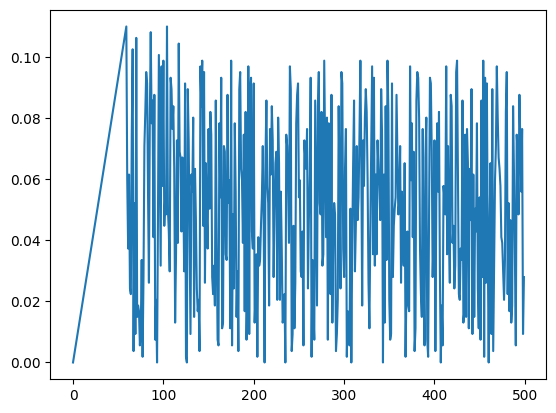

In [57]:
plt.plot(agent3.bids)

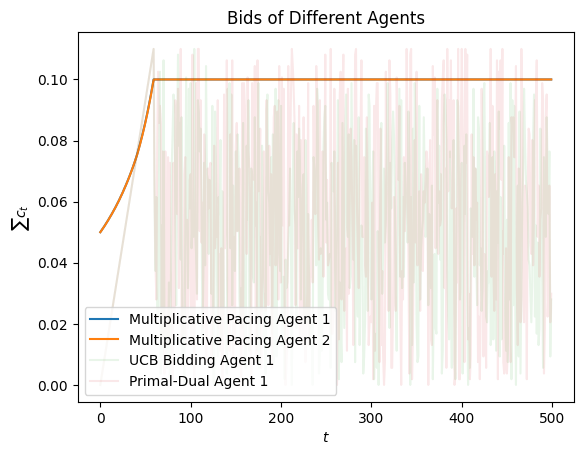

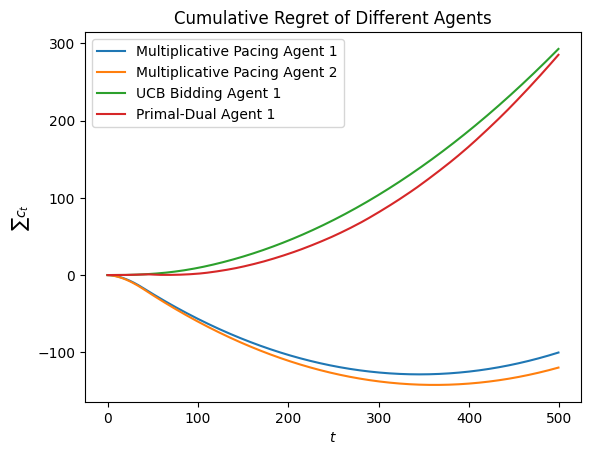

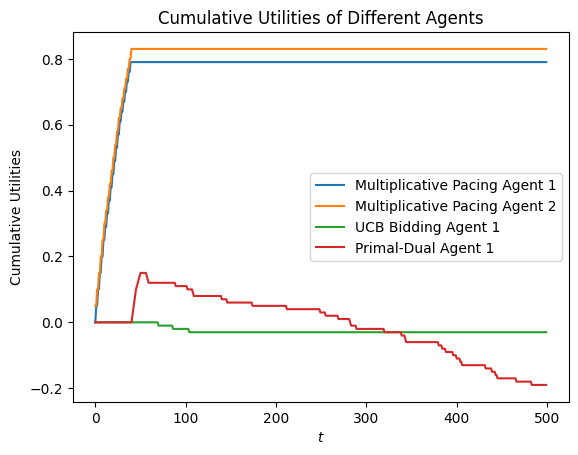

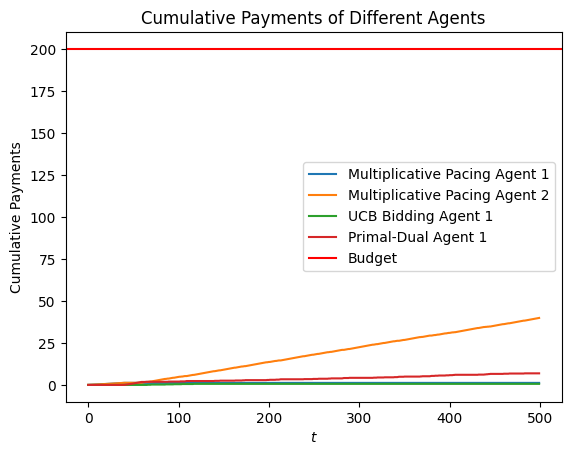

In [58]:
plt.plot(agent1.bids, label= agent1.name)
plt.plot(agent2.bids, label= agent2.name)
plt.plot(agent3.bids, label= agent3.name, alpha=0.1)
plt.plot(agent4.bids, label= agent4.name, alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Bids of Different Agents')
plt.show()

for agent in agents:
    plt.plot(agent.cumulative_regret, label= agent.name)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.legend()
plt.title('Cumulative Regret of Different Agents')
plt.show()

for agent in agents:
    plt.plot(agent.cum_utilities, label= agent.name)
plt.xlabel('$t$')
plt.ylabel('Cumulative Utilities')
plt.legend()
plt.title('Cumulative Utilities of Different Agents')
plt.show()

for agent in agents:
    plt.plot(agent.cum_payments, label= agent.name)
plt.xlabel('$t$')
plt.ylabel('Cumulative Payments')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Different Agents')
plt.show()